In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

strategies used {'random_crop': True, 'semantic_label_inpainting_pair': False, 'semantic_label_copy_paste_pair': False}
3378
2799
1280x1280 or 1536x1536 image
Original Mean: [83.50584717 86.38383118 72.72856445], Corner Mean: [106.38469971 110.58099609  92.95252441]
Original Std: [53.32237454 53.25762933 49.044096  ], Corner Std: [38.43152662 35.23944839 38.38499999]
Threshold: 0.3
is_similar_magnitude: False
Original Mean: [83.50584717 86.38383118 72.72856445], Corner Mean: [51.00213623 54.11223389 43.52250732]
Original Std: [53.32237454 53.25762933 49.044096  ], Corner Std: [49.0133122  50.46736379 42.53393086]
Threshold: 0.3
is_similar_magnitude: False
joplin-tornado_00000009_pre_disaster.png


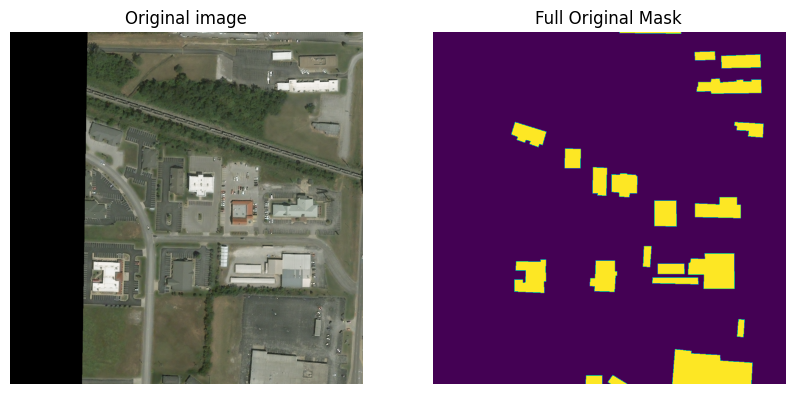

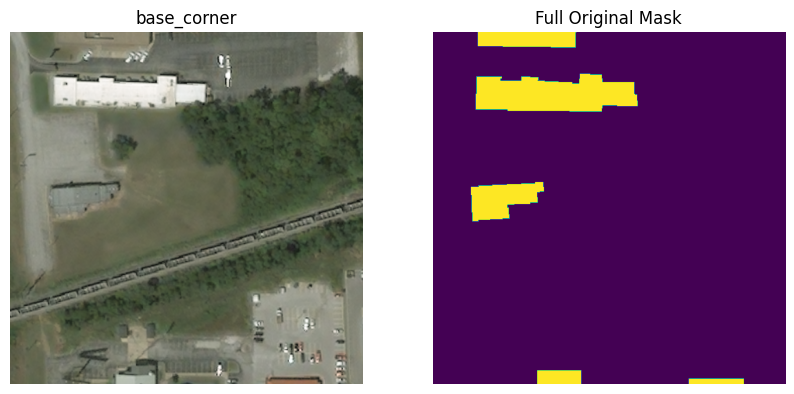

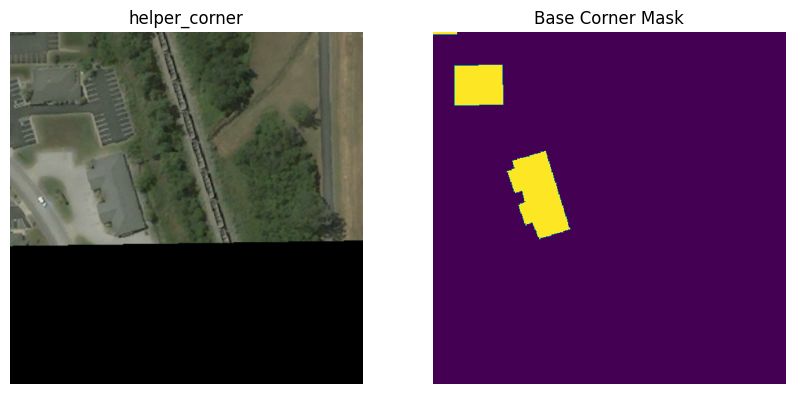

1280x1280 or 1536x1536 image
Original Mean: [83.50698471 86.38509327 72.72981517], Corner Mean: [117.11830817 119.42980957 104.00833978]
Original Std: [53.3158818  53.2512679  49.03831167], Corner Std: [33.03826118 31.65674905 33.69074886]
Threshold: 0.3
is_similar_magnitude: False
Original Mean: [83.50698471 86.38509327 72.72981517], Corner Mean: [51.0037757  54.11393568 43.52382406]
Original Std: [53.3158818  53.2512679  49.03831167], Corner Std: [49.00920732 50.46340169 42.53013114]
Threshold: 0.3
is_similar_magnitude: False
joplin-tornado_00000009_pre_disaster.png


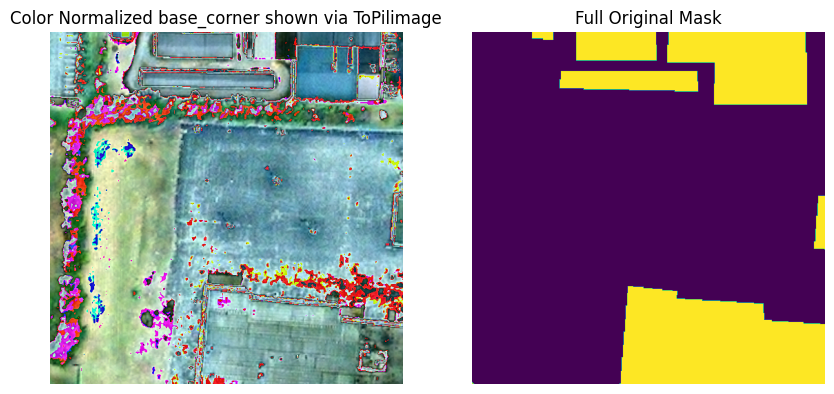

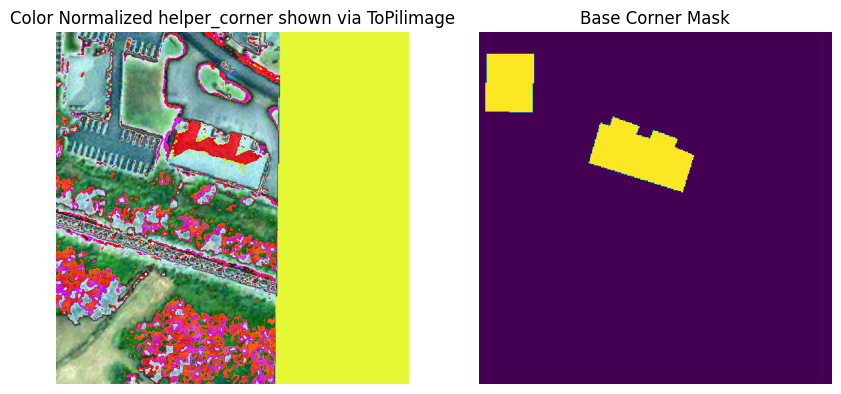

In [54]:
# Import necessary modules and classes
import ever as er
import torch
import numpy as np
import cv2
import random
from PIL import Image
from skimage.io import imread

from core import field
from core.dataset import ColorAugDataset
from torch.utils.data import ConcatDataset
from data.xview2.xview2_dataset import PreCachedXview2Building
from data.xview2.xview2_loader import PreCachedXview2BuildingLoader
from configs.trainxView2.r50_farseg_changemixin_inpainting import config
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

# Load data using the configuration path and model directory
image_dir=("./xview2/tier3/images", "./xview2/train/images")
target_dir=("./xview2/tier3/targets", "./xview2/train/targets")

strategies = dict(
                random_crop=True,
                semantic_label_inpainting_pair=False,
                semantic_label_copy_paste_pair=False,
            )

print(f"strategies used {strategies}")


geo_transform=config['data']['train']['params']['geo_transforms']

# Create the dataset without any changes
dataset_list = []
for im_dir, target_dir in zip(
    image_dir, target_dir
):
    dataset_list.append(PreCachedXview2Building(im_dir, target_dir, geo_transform, strategies))

dataset = ConcatDataset(dataset_list)

# Verify that the DataLoader is not empty
if len(dataset) == 2799:
    raise ValueError("The DataLoader is empty. Please check the dataset and configuration.")

normalized_dataset = ColorAugDataset(
                dataset,
                geo_transform=None,
                color_transform=config['data']['train']['params']['color_transforms'],
                common_transform=config['data']['train']['params']['common_transforms'],
            )

# Retrieve one sample from the dataset
# 1 => empty data_set test value
# 5 => data with empty corner values (black screen)
# 25 => good filled
idx = 9

# for i in range(10):
#     x, y = dataset[i]

x, y = dataset[idx]
print(y["image_filename"])

org_img = imread("./xview2/tier3/images/"+y["image_filename"])
org_mask = imread("./xview2/tier3/targets/"+y["image_filename"].replace(".png", "_target.png"))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original image')
plt.imshow(org_img)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Full Original Mask')
plt.imshow(org_mask)
plt.axis('off')

#######
base_corner_np = x[:, :, :3]
helper_corner_np = x[:, :, 3:]
mask = y[field.MASK1]
mask2 = y[field.VMASK2]
#######


# print("base_corner", base_corner_np.dtype)
# print("base_corner shape", base_corner_np.shape)
# print("base_mask", mask.dtype)
# print("blended_corner", helper_corner_np.dtype)
# print("base_corner shape", helper_corner_np.shape)
# print("blended_mask", mask2.dtype)
to_pil = ToPILImage()
# Step 3: Visuazlize the original image and mask
plt.figure(figsize=(10, 5))  # Adjust the figsize parameter to increase the size
plt.subplot(1, 2, 1)
plt.title('base_corner')
plt.imshow(base_corner_np)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Full Original Mask')
plt.imshow(mask)
plt.axis('off')
plt.show()

# Step 4: Visualize the base corner image/mask and helper corner image/mask
to_pil = ToPILImage()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('helper_corner')
plt.imshow(helper_corner_np)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Base Corner Mask')
plt.imshow(mask2)
plt.axis('off')
plt.show()


# x1, y1, x2, y2 = normalized_dataset[idx]

# base_corner_np = x1
# helper_corner_np = x2
# mask = y1
# mask2 = y2

x, y = normalized_dataset[idx]
print(y["image_filename"])

# after color aug
base_corner_np = x[:3, :, :]
helper_corner_np = x[ 3:, :, :]
mask = y[field.MASK1]
mask2 = y[field.VMASK2]


# info = np.iinfo(data.dtype) # Get the information of the incoming image type
# data = data.astype(np.float64) / info.max # normalize the data to 0 - 1
# data = 255 * data # Now scale by 255
# img = data.astype(np.uint8)
# cv2.imshow("Window", img)

# print("base_corner", base_corner_np.dtype)
# print("base_corner shape", base_corner_np.shape)
# print("base_mask", mask.dtype)
# print("blended_corner", helper_corner_np.dtype)
# print("base_corner shape", helper_corner_np.shape)
# print("blended_mask", mask2.dtype)

to_pil = ToPILImage()
# Step 3: Visuazlize the original image and mask
plt.figure(figsize=(10, 5))  # Adjust the figsize parameter to increase the size
plt.subplot(1, 2, 1)
plt.title('Color Normalized base_corner shown via ToPilimage')
plt.imshow(to_pil(base_corner_np))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Full Original Mask')
plt.imshow(mask)
plt.axis('off')
plt.show()

# Step 4: Visualize the base corner image/mask and helper corner image/mask
to_pil = ToPILImage()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Color Normalized helper_corner shown via ToPilimage')
plt.imshow(to_pil(helper_corner_np))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Base Corner Mask')
plt.imshow(mask2)
plt.axis('off')
plt.show()

In [21]:
import glob
import os
from skimage.io import imread

target_dir=("./xview2/tier3/targets")
image_dir=("./xview2/tier3/images")

image_fps = sorted(
    [fp for fp in glob.glob(os.path.join(image_dir, "*.png")) if "pre" in fp]
)

target_fps =[
    os.path.join(image_dir, os.path.basename(fp.replace("_target.png", ".png")))
    for fp in image_fps
]

print(len(image_fps))
print(len(target_fps))

6369
6369


In [25]:
# Import necessary modules and classes
import ever as er
import torch
import numpy as np
import cv2
import random
from PIL import Image

from core import field
from core.dataset import ColorAugDataset
from torch.utils.data import ConcatDataset
from data.xview2.xview2_dataset import PreCachedXview2Building
from data.xview2.xview2_loader import PreCachedXview2BuildingLoader
from configs.trainxView2.r50_farseg_changemixin_inpainting import config
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

target_dir=("./xview2/tier3/targets")
image_dir=("./xview2/tier3/images")

image_fps = sorted(
    [fp for fp in glob.glob(os.path.join(image_dir, "*.png")) if "pre" in fp]
)

# Extract the base filenames (without the directory and suffixes)
base_image_filenames = set(
    os.path.basename(fp).replace("_pre_disaster.png", "") for fp in image_fps
)

# Construct the target filenames
constructed_target_fps = sorted(
    os.path.join(target_dir, f"localization_{base_name.replace('_', '-')}_target.png")
    for base_name in base_image_filenames
)

# Filter the target files that exist
target_fps = [fp for fp in constructed_target_fps if os.path.isfile(fp)]

target = imread(target_fps[1])
image = imread(image_fps[1])


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Helper Corner Image')
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Helper Corner Mask')
plt.imshow(target)
plt.axis('off')
plt.show()


to_pil = ToPILImage()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Helper Corner Image')
plt.imshow(image)
plt.axis('off')
plt.show()

IndexError: list index out of range

In [ ]:
# Import strategy used
idx = 1
x, y = dataset[idx]
img = np.array(x)
mask = np.array(y[field.MASK1])
mask2 = np.array(y[field.VMASK2])

print(x.dtype)
print(mask.dtype)
print(img.dtype)

half_width = x.shape[1] // 2
base_corner_tensor = x[:3, :, :]
helper_corner_tensor = x[3:, :, :]


to_pil = ToPILImage()
# Step 3: Visuazlize the original image and mask
plt.figure(figsize=(10, 5))  # Adjust the figsize parameter to increase the size
plt.subplot(1, 2, 1)
plt.title('Full Original Image')
plt.imshow(to_pil(base_corner_tensor))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Full Original Mask')
plt.imshow(mask)
plt.axis('off')
plt.show()

# Step 4: Visualize the base corner image/mask and helper corner image/mask
to_pil = ToPILImage()
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Base Corner Image')
plt.imshow(to_pil(helper_corner_tensor))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Base Corner Mask')
plt.imshow(mask2)
plt.axis('off')
plt.show()

In [ ]:
import json
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from glob import glob

# Paths to your directories
image_dir = "./xview2/tier3/images"
target_dir = "./xview2/tier3/target"
labels_dir = "./xview2/tier3/labels"

# Create the target directory if it does not exist
os.makedirs(target_dir, exist_ok=True)

# Get the list of all label files
label_files = glob(os.path.join(labels_dir, "*.json"))

# Function to convert polygon coordinates from WKT to a list of (lat, lng) tuples
def wkt_to_coords(wkt):
    coords = wkt.replace('POLYGON ((', '').replace('))', '').split(', ')
    coords = [tuple(map(float, coord.split())) for coord in coords]
    return coords

# Function to convert (lat, lng) coordinates to pixel coordinates
def latlng_to_pixel(coords, width, height):
    return [(int((lng + 180) * (width / 360)), int((90 - lat) * (height / 180))) for lng, lat in coords]

# Process each label file
for label_file in label_files:
    with open(label_file, 'r') as f:
        data = json.load(f)
    
    # Derive the corresponding image file name
    image_filename = os.path.basename(label_file).replace(".json", ".png")
    image_path = os.path.join(image_dir, image_filename)
    print("Attempting to read image from:", image_path)

    
    # Read the corresponding image to get its dimensions
    if not os.path.exists(image_path):
        print(f"Image file {image_path} does not exist. Skipping.")
        continue
    
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    # Create a blank image for the mask
    mask = np.zeros((height, width), dtype=np.uint8)

    # Iterate through each feature (polygon) in the JSON file
    for feature in data['features']['lng_lat']:
        wkt = feature['wkt']
        
        # Extract the coordinates from the WKT string
        coords = wkt_to_coords(wkt)
        
        # Convert coordinates to pixel values
        polygon = np.array(latlng_to_pixel(coords, width, height))
        
        # Draw the polygon on the mask
        cv2.fillPoly(mask, [polygon], 1)
    
    # Save the mask image
    mask_filename = image_filename.replace(".png", "_target.png")
    mask_filepath = os.path.join(target_dir, mask_filename)
    cv2.imwrite(mask_filepath, mask)

    print(f"Created mask for {image_filename} and saved to {mask_filepath}")

print('Masks have been created successfully.')


In [ ]:
print('Masks have been created successfully.')